# LUS-CS433

## 1. Code Exploration

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import glob

### Downloading data

## 2. Data Exploration

In [2]:
"""# getting the list of names
!ls LUS\ images/negative > neg_names.csv
!ls LUS\ images/positive > pos_names.csv

neg = pd.read_csv('neg_names.csv', header=None)
pos = pd.read_csv('pos_names.csv', header=None)

data = neg.append(pos, ignore_index=True)
data

pos = pd.read_csv('pos_names.csv', header=None)

# removing .png extension
pos[0] = pos[0].apply(lambda x: x[:-4])

# extracting site
pos[0] = pos[0].apply(lambda x: x.split('_')[2])

pos

sums = pd.get_dummies(pos).sum()

plt.bar(sums.index, sums.values)
plt.xlabel('Site')
plt.ylabel('Count')
plt.tight_layout()"""

"# getting the list of names\n!ls LUS\\ images/negative > neg_names.csv\n!ls LUS\\ images/positive > pos_names.csv\n\nneg = pd.read_csv('neg_names.csv', header=None)\npos = pd.read_csv('pos_names.csv', header=None)\n\ndata = neg.append(pos, ignore_index=True)\ndata\n\npos = pd.read_csv('pos_names.csv', header=None)\n\n# removing .png extension\npos[0] = pos[0].apply(lambda x: x[:-4])\n\n# extracting site\npos[0] = pos[0].apply(lambda x: x.split('_')[2])\n\npos\n\nsums = pd.get_dummies(pos).sum()\n\nplt.bar(sums.index, sums.values)\nplt.xlabel('Site')\nplt.ylabel('Count')\nplt.tight_layout()"

## 3. Creating Datasets

### 3.1 Creating file folders

In [33]:
"""! mkdir data/LUS_proc_images
! mkdir data/LUS_proc_images/train
! mkdir data/LUS_proc_images/val
! mkdir data/LUS_proc_images/train/true
! mkdir data/LUS_proc_images/train/false
! mkdir data/LUS_proc_images/val/true
! mkdir data/LUS_proc_images/val/false """

! mkdir data/butter_proc_images_2
! mkdir data/butter_proc_images_2/train
! mkdir data/butter_proc_images_2/val
! mkdir data/butter_proc_images_2/test
! mkdir data/butter_proc_images_2/train/true
! mkdir data/butter_proc_images_2/train/false
! mkdir data/butter_proc_images_2/val/true
! mkdir data/butter_proc_images_2/val/false

### 3.2 Image preprocessing

We start by creating a mask that we will use to crop images, getting rid of features on the images (such as the scale, or name of site) that could otherwise perturb the training.
The mask has been crafted manually, as we did not have time to implement automatic edge detrection or similar mechanism to automate the process.

In [34]:
# Main mask used to capture the relevant portion of LUS images. Crafted manually. Is [1,1,1] where image is relevant

# Image dimensions
nb_rows = 1080
nb_cols = 792
nb_channels = 3

mask = np.zeros([nb_rows, nb_cols, nb_channels])

# Filling mask
for row in range(nb_rows):
    for col in range(nb_cols):
        # Delimitations of the cone like portion of a LUS image
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + nb_cols-293 > col:
            mask[row, col] = [1,1,1]

#### 3.2.1 Obtaining "True" images

We then create a function that will run over our expert selected images, crop them, and organise them in a folder architecture that will later be used through the PyTorch DataLoader class. We also select by hand a few images that will be used as a test set.

In [44]:
# patient ids used for the test set
test_ids = ['_151_','_136_', '_117_', '_45_', '_16_']

def read_crop(image_path, mask, nb_cols=792, nb_rows=1080):
    """
    Read image, resize to given dimensions and apply mask.
    
    Returns: image name, image
    """
    # Reading and masking image
    cv2_img = cv2.imread(image_path)
    masked_img = cv2.resize(cv2_img, (nb_cols, nb_rows))*mask

    # Selecting image name from path name
    img_name = image_path.split("/")[-1]
    
    return img_name, masked_img
    

def create_samples(nb_samples, ratio, read_path, write_path, mask):
    """
    Crops nb_spamples images from the given folder and 
    organises them in training, validation and test folders, in "true" labeled subfolders
    """
    images_path = glob.glob(read_path)
    
    # sparating test images and shuffling
    np.random.seed(1)
    images_path_test = [img for img in images_path if any([(id_ in img) for id_ in test_ids])] 
    images_path = [img for img in images_path if not any([(id_ in img) for id_ in test_ids])]
    images_path = np.random.permutation(images_path)
    
    train = int(nb_samples * ratio)
    
    # Writing training and validation images to folder
    for i, image in enumerate(images_path[:nb_samples]):
        img_name, masked_img = read_crop(image, mask)
        
        if i >= train:
            cv2.imwrite(f"{write_path}/val/true/{img_name}", masked_img)
        else:
            success = cv2.imwrite(f"{write_path}/train/true/{img_name}", masked_img)
            
    # Writing test images to folder
    for image in images_path_test:
        img_name, masked_img = read_crop(image, mask, nb_cols, nb_rows)
        cv2.imwrite(f"{write_path}/test/{img_name}", masked_img)

Extracting and organising the "true" label images.

In [46]:
# Make sure that the files are empty
! rm -rfv data/butter_proc_images_2/val/true/*
! rm -rfv data/butter_proc_images_2/train/true/*
! rm -rfv data/butter_proc_images_2/test/*

# Generates the samples
nb_samples = 300
ratio = 0.8
read_path = "data/Ultrason butterflynetwork/*.png"
write_path = "data/butter_proc_images_2"
create_samples(nb_samples, ratio, read_path, write_path, mask)

'# Make sure that the files are empty\n! rm -rfv data/butter_proc_images_2/val/true/*\n! rm -rfv data/butter_proc_images_2/train/true/*\n! rm -rfv data/butter_proc_images_2/test/*\n\n# Generates the samples\nnb_samples = 300\nratio = 0.8\nread_path = "data/Ultrason butterflynetwork/*.png"\nwrite_path = "data/butter_proc_images_2"\ncreate_samples(nb_samples, ratio, read_path, write_path, mask)'

#### 3.2.1 Obtaining "False" images

Now that the expert images have been processed and organised we need to obtain data corresponding to the opposite label, namely images that an expert clinician would not have selected from a video, as they would prove to be poor material for diagnositic.
We try a selection method based on the average brightness of the image. If it is too low or too high, we consider the image is bad and thus save it as a "false" labeled data.

In [114]:
def compute_mean(img, mask):
    """
    Computes the mean brightness over the masked area (mask should already have been applied to the image)
    """
    active = np.sum(mask)/nb_channels
    mean = np.mean(img)*(nb_cols*nb_rows/active)

    return mean
    
# TODO is it used ?
def compute_mean_std(img, mask):
    len_x,len_y, _ = img.shape
    
    # Compute mean brightness
    mean = mean(img, mask)
    var = 0
    for x in range(len_x):
        for y in range(len_y):
            if(mask[x,y,0]==1):
                var += (img[x,y,0] - mean)**2
    
    var /= active
    
    return mean, np.sqrt(var)
            

#### Compute mean brightness over all sample

In [54]:
def create_brightness_df(path):
    df = pd.DataFrame(columns = ['mean', 'std'])
    images_path = glob.glob(path)
    for i,image in enumerate(images_path):
        img = cv2.imread(image)
        m, s = compute_mean_std(img, mask)
        df.loc[i] = [m, s]
        
    return df

In [56]:
df = create_brightness_df("data/butter_proc_images_2/train/true/*.png")

In [ ]:
df.to_csv("mean_std_butter_300.csv")

<AxesSubplot:>

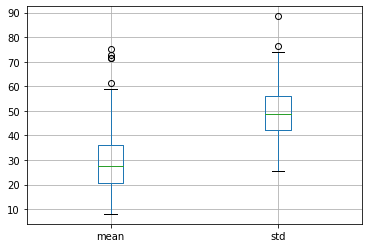

In [57]:
df.boxplot()

<AxesSubplot:>

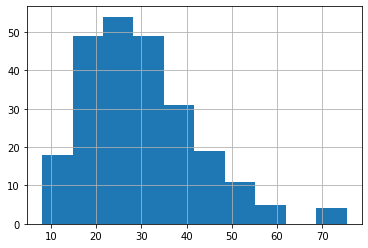

In [58]:
df['mean'].hist()

<AxesSubplot:>

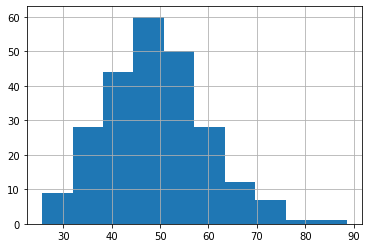

In [59]:
df['std'].hist()

In [60]:
df.describe()

,mean,std
count,240.000000,240.000000
mean,30.017529,49.137431
std,12.483484,10.542679
min,8.083843,25.636854
25%,20.744722,42.253468
50%,27.506638,48.658765
75%,36.293187,55.868505
max,75.345567,88.525017


array([[<AxesSubplot:title={'center':'mean'}>,
        <AxesSubplot:title={'center':'std'}>]], dtype=object)

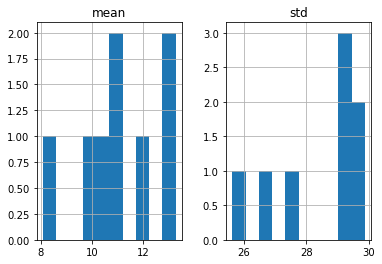

In [61]:
df[(df['mean']<15) & (df['std']<32)].hist()

<AxesSubplot:xlabel='std', ylabel='mean'>

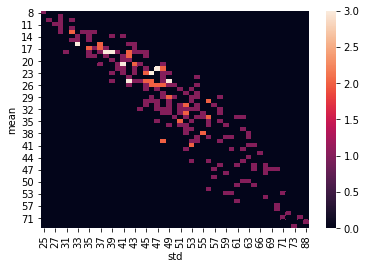

In [62]:
df2 = df.astype(int)
df2 = pd.crosstab(df2['mean'], df2['std'])
sns.heatmap(df2)

In [113]:
# TODO justify these
MEAN_UP, MEAN_DOWN = 7, 120  #mean_down, mean_up (based around the described df frame)
LAST_WRITE_NB_FRAMES = 20

In [8]:
# TODO comment
def split_video(video_path):
    video = cv2.VideoCapture(video_path)
    i = 0
    df_video = pd.DataFrame(columns = ['mean', 'std'])
    while(video.isOpened()):
        ret, image = video.read()
        if ret == True:
            video.set(cv2.CAP_PROP_POS_MSEC,(i*1000))
            image = image * mask
            m, s = compute_mean_std(image, mask)
            df_video.loc[i] = [m[0,0], s[0,0]]
            i += 1
        else:
            break
    video.release()
    return df_video

In [109]:
#Creates samples from a video
def create_samples_from_video(read_path, write_path, sample_count, max_count):
    """
    Select images from videos based on brightness criteria and write them to the corresponding folder
    Can not select more than max_count images
    Images have to be separated by a minimum number of frames in the video as to avoid selecting nigh identical images.
    """
    video = cv2.VideoCapture(read_path)
    i = 0
    last_write = 100 #variable to avoid writing 2 images that are almost the same 
    
    while(video.isOpened() and sample_count < max_count):
        ret, image = video.read()
        if ret == True:
            #if we have access to an image, we check the mean, after applying the mask
            image = image * mask
            mean = compute_mean(image, mask)
            
            if (mean > MEAN_UP or mean < MEAN_DOWN) and (last_write > LAST_WRITE_NB_FRAMES) :
                video_id = read_path.replace('.', '/').split("/")[-2]
                cv2.imwrite(f"{write_path}/{video_id}_{i}.png", image)
                sample_count = sample_count + 1
                i+=1
                last_write = 0
            
            last_write += 1
        else:
            #need to get out the while loop if we can't read a file
            break
    video.release()
    return sample_count

In [110]:
def multiple_videos_sample(read_path, write_path, nb_samples, train_ratio):
    """
    Obtain nb_samples images from videos based on brightness criteria
    and splits them between the training and validation folders
    """
    videos_path = np.random.permutation(glob.glob(read_path))
    nb_samples_train = int(nb_samples * train_ratio)
    sample_count = 0
    
        
    # Writing images to respective folders
    for video_path in videos_path:
        if sample_count >= nb_samples:
            break
        elif sample_count < nb_samples_train:
            sample_count = create_samples_from_video(video_path, f"{write_path}/train/false", sample_count, max_count=nb_samples)
        else:
            sample_count = create_samples_from_video(video_path, f"{write_path}/val/false", sample_count, max_count=nb_samples)
            
    if sample_count < nb_samples:
        print(f"Could not obtain enough samples: \nObtained : {sample_count} \nDemanded: {nb_samples}")

In [112]:
read_path = "data/Ultrason butterflynetwork/*.mp4"
nb_samples = 300
train_ratio = 0.8
multiple_videos_sample(read_path, write_path, nb_samples, train_ratio)

In [ ]:
"""# Renaming to appropriate format
def replace_dot_by_underscore(path):
    path_list = glob.glob(path)
    
    for old_path in path_list:
        new_path = old_path.replace(".", "_", 1)
        os.rename(old_path, new_path)
        
replace_dot_by_underscore("data/Ultrason butterflynetwork/*")"""

In [ ]:
df_split = split_video("data/Ultrason butterflynetwork/1_1_QAID_1.mp4")

In [ ]:
df_split

In [ ]:
df_split = split_video("data/Ultrason butterflynetwork/1_9_QLD.mp4")

In [135]:
df_video2 = df_video.astype(int)
df_video2 = pd.crosstab(df_video2['mean'], df_video2['std'])
sns.heatmap(df_video2)

Trying to regroup all formats used

In [149]:
butterfly_img_path = glob.glob("data/Ultrason butterflynetwork/*.png")
lus_neg_img_path = glob.glob("data/ppredictus_images/LUS images/negative/*.png")
vid_img_path = glob.glob("data/Ultrason butterflynetwork/*.mp4")

def count_formats(path_list):
    counts = {}
    for path in path_list: 
        key = cv2.imread(path).shape
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts

def count_formats_vid(path_list):
    counts = {}
    for path in path_list:
        video = cv2.VideoCapture(path)
        success, img = video.read()
        
        if success == False :
            raise("Exception nulle")
        
        key = img.shape
        video.release()
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts